In [1]:
from pydantic import BaseModel, Field
from typing import Dict, NewType, Any
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import time
import rich

EVM types and environment

In [22]:
def bounded_int(bits: int, signed: bool):
    """
    a factory for types like int128, uint256 etc.
    """
    name = f"{'u' if not signed else ''}int{bits}"

    def check_bounds(self, value=0):
        if signed:
            assert -2**(bits-1) <= value <= 2**(bits-1)-1, 'value outside domain'
        else:
            assert 0 <= value <= 2**(bits)-1, 'value outside domain'

    def plus(self, other):
        return self.__class__(int(self) + int(other))
    
    def minus(self, other):
        return self.__class__(int(self) - int(other))

    def multiply(self, other):
        return self.__class__(int(self) * int(other))

    def divide(self, other):
        return self.__class__(int(self) // int(other))

    return type(
        name, (int,), {
            '__init__': check_bounds,
            '__add__': plus,
            '__sub__': minus,
            '__mul__': multiply,
            '__truediv__': divide,
        }
    )

int128 = bounded_int(128, True)
uint256 = bounded_int(256, False)
uint8 = bounded_int(8, False)


# patch decorators
identity = lambda f: f
view = identity
nonpayable = identity
internal = identity
external = identity
public = identity
indexed = identity
immutable = identity
constant = identity
nonreentrant = lambda name: identity
empty = lambda t: t()

def convert(v, t):
    return t(v)

# other types
address = NewType('adderss', str)
ZERO_ADDRESS = 'zero'

verbose = False

class Event(BaseModel):
    def __init__(self, *args, **kwds):
        super().__init__(*args, **kwds)
        if verbose:
            print(f'log {repr(self)}')

class Struct(BaseModel):
    pass

class Interface(BaseModel):
    pass

class HashMap(dict):
    def __init__(self, key_type, default_factory):
        self.key_type = key_type
        self.default_factory = default_factory
    
    def __missing__(self, key):
        return self.default_factory()


class MessageContext(BaseModel):
    sender: address = 'bunny'


class BlockContext(BaseModel):
    number: int = 0
    timestamp: int = int(time.time())


class Contract(BaseModel):
    pass

block = BlockContext(number=15013677, timestamp=1655999166)
msg = MessageContext(sender='bunny')


class ERC20(Contract):
    name: str
    balances: Dict[address, uint256] = HashMap(address, uint256)
    allowance: Dict[address, Dict[address, uint256]] = HashMap(address, lambda: HashMap(address, uint256))

    class Transfer(Event):
        source: address
        target: address
        amount: uint256
    
    def mint(self, to, amount):
        self.balances[to] += amount
        ERC20.Transfer(source=ZERO_ADDRESS, target=to, amount=amount)
        return True

    def transfer(self, to, amount):
        self.balances[msg.sender] -= amount
        self.balances[to] += amount
        ERC20.Transfer(source=msg.sender, target=to, amount=amount)
        return True

    def transferFrom(self, source, to, amount):
        # self.allowance[source][msg.sender] -= amount
        self.balances[source] -= amount
        self.balances[to] += amount
        ERC20.Transfer(source=source, target=to, amount=amount)
        return True

    def approve(self, spender, amount):
        if spender not in self.allowance:
            self.allowance[spender] = HashMap(address, uint256)
        self.allowance[spender][msg.sender] += amount
        return True

token = ERC20(name='YFI')
token.mint('bunny', 100)
token.transfer('doggie', 100)
token

ERC20(name='YFI', balances={'bunny': 0, 'doggie': 100}, allowance={})

veYFI contract model

In [25]:
# @version 0.3.4
"""
@title Voting YFI
@author Curve Finance, Yearn Finance
@license MIT
@notice
    Votes have a weight depending on time, so that users are
    committed to the future of whatever they are voting for.
@dev
    The voting power is capped at 4 years, but the lock can exceed that duration.
    Vote weight decays linearly over time.
    A user can unlock funds early incurring a penalty.
"""

class RewardPool(Contract):
    address: str = 'reward_pool'

    def burn(self) -> bool:
        return True

class Point(Struct):
    bias: int128 = 0
    slope: int128 = 0 # - dweight / dt
    ts: uint256 = 0
    blk: uint256 = 0 # block

class LockedBalance(Struct):
    amount: uint256 = 0
    end: uint256 = 0
    decay: uint256 = 0

class Withdrawn(Struct):
    amount: uint256
    penalty: uint256

class ModifyLock(Event):
    sender: indexed(address)
    user: indexed(address)
    amount: uint256
    locktime: uint256
    ts: uint256

class Withdraw(Event):
    user: indexed(address)
    amount: uint256
    ts: uint256

class Penalty(Event):
    user: indexed(address)
    amount: uint256
    ts: uint256

class Supply(Event):
    old_supply: uint256
    new_supply: uint256
    ts: uint256

class Initialized(Event):
    token: ERC20
    reward_pool: RewardPool

YFI: immutable(ERC20) = ERC20(name='yfi')
REWARD_POOL: immutable(RewardPool) = RewardPool(address='reward_pool')

DAY: constant(uint256) = 86400
WEEK: constant(uint256) = 7 * 86400  # all future times are rounded by week
MAX_LOCK_DURATION: constant(uint256) = 4 * 365 * 86400  # 4 years
SCALE: constant(uint256) = 10 ** 18
MAX_PENALTY_RATIO: constant(uint256) = SCALE * 3 / 4  # 75% for early exit of max lock

class veYFI(Contract):
    supply: uint256 = 0
    locked: Dict[address, LockedBalance] = HashMap(address, LockedBalance)
    epoch: uint256 = 0
    point_history: Dict[uint256, Point] = HashMap(uint256, Point)
    user_point_history: Dict[address, Dict[uint256, Point]] = HashMap(address, lambda: HashMap(uint256, Point)) # user -> Point[user_epoch]
    user_point_epoch: Dict[address, uint256] = HashMap(address, uint256)
    slope_changes: Dict[uint256, int128] = HashMap(uint256, int128) # time -> signed slope change

    @external
    def init(self):
        """
        @notice Contract constructor
        @param token YFI token address
        @param reward_pool Pool for early exit penalties
        """
        self.point_history[0].blk = block.number
        self.point_history[0].ts = block.timestamp

        Initialized(token=YFI, reward_pool=REWARD_POOL)


    @view
    @external
    def get_last_user_slope(self, addr: address) -> int128:
        """
        @notice Get the most recently recorded rate of voting power decrease for `addr`
        @param addr Address of the user wallet
        @return Value of the slope
        """
        uepoch: uint256 = self.user_point_epoch[addr]
        return self.user_point_history[addr][uepoch].slope


    @view
    @external
    def user_point_history__ts(self, addr: address, idx: uint256) -> uint256:
        """
        @notice Get the timestamp for checkpoint `idx` for `addr`
        @param addr User wallet address
        @param idx User epoch number
        @return Epoch time of the checkpoint
        """
        return self.user_point_history[addr][idx].ts


    @internal
    def _checkpoint(self, addr: address, old_locked: LockedBalance, new_locked: LockedBalance):
        """
        @notice Record global and per-user data to checkpoint
        @param addr User's wallet address. No user checkpoint if 0x0
        @param old_locked Pevious locked amount / end lock time for the user
        @param new_locked New locked amount / end lock time for the user
        """
        u_old: Point = Point()
        u_new: Point = Point()
        old_dslope: int128 = 0
        new_dslope: int128 = 0
        _epoch: uint256 = self.epoch

        if addr != ZERO_ADDRESS:
            # Calculate slopes and biases
            # Kept at zero when they have to
            if old_locked.end > block.timestamp and old_locked.amount > 0:
                u_old.slope = old_locked.amount // MAX_LOCK_DURATION
                u_old.bias = u_old.slope * convert(old_locked.end - block.timestamp, int128)
            if new_locked.end > block.timestamp and new_locked.amount > 0:
                u_new.slope = new_locked.amount // MAX_LOCK_DURATION
                u_new.bias = u_new.slope * convert(new_locked.end - block.timestamp, int128)

            # Read values of scheduled changes in the slope
            # old_locked.end can be in the past and in the future
            # new_locked.end can ONLY by in the FUTURE unless everything expired: than zeros
            old_dslope = self.slope_changes[old_locked.end]
            if new_locked.end != 0:
                if new_locked.end == old_locked.end:
                    new_dslope = old_dslope
                else:
                    new_dslope = self.slope_changes[new_locked.end]

        last_point: Point = Point(bias=0, slope=0, ts=block.timestamp, blk=block.number)
        if _epoch > 0:
            last_point = self.point_history[_epoch].copy()
        last_checkpoint: uint256 = last_point.ts
        # initial_last_point is used for extrapolation to calculate block number
        # (approximately, for *At methods) and save them
        # as we cannot figure that out exactly from inside the contract
        initial_last_point: Point = last_point.copy()
        block_slope: uint256 = 0  # dblock/dt
        if block.timestamp > last_point.ts:
            block_slope = SCALE * (block.number - last_point.blk) // (block.timestamp - last_point.ts)
        # If last point is already recorded in this block, slope=0
        # But that's ok b/c we know the block in such case

        # Go over weeks to fill history and calculate what the current point is
        t_i: uint256 = (last_checkpoint // WEEK) * WEEK
        for i in range(255):
            # Hopefully it won't happen that this won't get used in 5 years!
            # If it does, users will be able to withdraw but vote weight will be broken
            t_i += WEEK
            d_slope: int128 = 0
            if t_i > block.timestamp:
                t_i = block.timestamp
            else:
                d_slope = self.slope_changes[t_i]
            last_point.bias -= last_point.slope * convert(t_i - last_checkpoint, int128)
            last_point.slope += d_slope
            if last_point.bias < 0:  # This can happen
                last_point.bias = 0
            if last_point.slope < 0:  # This cannot happen - just in case
                last_point.slope = 0
            last_checkpoint = t_i
            last_point.ts = t_i
            last_point.blk = initial_last_point.blk + block_slope * (t_i - initial_last_point.ts) // SCALE
            _epoch += 1
            if t_i == block.timestamp:
                last_point.blk = block.number
                break
            else:
                self.point_history[_epoch] = last_point.copy()

        self.epoch = _epoch
        # Now point_history is filled until t=now

        if addr != ZERO_ADDRESS:
            # If last point was in this block, the slope change has been applied already
            # But in such case we have 0 slope(s)
            last_point.slope += (u_new.slope - u_old.slope)
            last_point.bias += (u_new.bias - u_old.bias)
            if last_point.slope < 0:
                last_point.slope = 0
            if last_point.bias < 0:
                last_point.bias = 0

        # Record the changed point into history
        self.point_history[_epoch] = last_point.copy()

        if addr != ZERO_ADDRESS:
            # Schedule the slope changes (slope is going down)
            # We subtract new_user_slope from [new_locked.end]
            # and add old_user_slope to [old_locked.end]
            if old_locked.end > block.timestamp:
                # old_dslope was <something> - u_old.slope, so we cancel that
                old_dslope += u_old.slope
                if new_locked.end == old_locked.end:
                    old_dslope -= u_new.slope  # It was a new deposit, not extension
                self.slope_changes[old_locked.end] = old_dslope

            if new_locked.end > block.timestamp:
                if new_locked.end > old_locked.end:
                    new_dslope -= u_new.slope  # old slope disappeared at this point
                    self.slope_changes[new_locked.end] = new_dslope
                # else: we recorded it already in old_dslope

            # Now handle user history
            user_epoch: uint256 = self.user_point_epoch[addr] + 1

            self.user_point_epoch[addr] = user_epoch
            u_new.ts = block.timestamp
            u_new.blk = block.number
            # fix for hashmap impl bug
            if addr not in self.user_point_history:
                self.user_point_history[addr] = HashMap(uint256, Point)
            self.user_point_history[addr][user_epoch] = u_new.copy()


    @external
    def checkpoint(self):
        """
        @notice Record global data to checkpoint
        """
        self._checkpoint(ZERO_ADDRESS, empty(LockedBalance), empty(LockedBalance))

    def checkpoint_user(self, user):
        """
        @notice Record global data to checkpoint
        """
        self._checkpoint(user, self.locked[user], self.locked[user])


    @external
    @nonreentrant('lock')
    def modify_lock(self, amount: uint256, unlock_time: uint256, user: address):
        """
        @notice Create or modify a lock for a user. Support deposits on behalf of a user.
        @dev
            Minimum deposit to create a lock is 1 YFI.
            You can lock for longer than 4 years, but the max voting power is capped at 4 years.
            You can only increase lock duration if it has less than 4 years remaining.
            You can decrease lock duration if it has more than 4 years remaining.
        @param amount YFI amount to add to a lock. 0 to not modify.
        @param unlock_time Unix timestamp when the lock ends, must be in the future. 0 to not modify.
        @param user A user to deposit to. If different from msg.sender, unlock_time has no effect
        """
        old_lock: LockedBalance = self.locked[user].copy()
        new_lock: LockedBalance = old_lock.copy()
        new_lock.amount += amount

        unlock_week: uint256 = 0
        # only a user can modify their own unlock time
        if msg.sender == user:
            if unlock_time != 0:
                unlock_week = uint256(unlock_time) / WEEK * WEEK  # Locktime is rounded down to weeks
                assert unlock_time > block.timestamp  #  dev: unlock time must be in the future
                if unlock_week - block.timestamp < MAX_LOCK_DURATION:
                    assert unlock_week > old_lock.end  # dev: can only increase lock duration
                else:
                    assert unlock_week > block.timestamp + MAX_LOCK_DURATION  # dev: can only decrease to ≥4 years
                new_lock.end = unlock_week

        # create lock
        if old_lock.amount == 0 and old_lock.end == 0:
            assert msg.sender == user  # dev: you can only create a lock for yourself
            assert amount >= 10 ** 18  # dev: minimum amount is 1 YFI
            assert unlock_week != 0  # dev: must specify unlock time in the future
        # modify lock
        else:
            assert old_lock.end > block.timestamp  # dev: lock expired

        supply_before: uint256 = self.supply
        self.supply = supply_before + amount
        self.locked[user] = new_lock
        
        self._checkpoint(user, old_lock.copy(), new_lock.copy())

        if amount > 0:
            assert YFI.transferFrom(msg.sender, 'veyfi', amount)

        Supply(old_supply=supply_before, new_supply=supply_before + amount, ts=block.timestamp)
        ModifyLock(sender=msg.sender, user=user, amount=new_lock.amount, locktime=new_lock.end, ts=block.timestamp)

        return new_lock


    @external
    @nonreentrant('lock')
    def withdraw(self) -> Withdrawn:
        """
        @notice Withdraw lock for a sender
        @dev
            If a lock has expired, sends a full amount to the sender.
            If a lock is still active, the sender pays a 75% penalty during the first year
            and a linearly decreasing penalty from 75% to 0 based on the remaining lock time.
        """
        old_locked: LockedBalance = self.locked[msg.sender]
        assert old_locked.amount > 0  # dev: create a lock first to withdraw
        
        time_left: uint256 = 0
        penalty: uint256 = 0

        if old_locked.end > block.timestamp:
            time_left = min(old_locked.end - block.timestamp, MAX_LOCK_DURATION)
            penalty_ratio: uint256 = min(time_left * SCALE / MAX_LOCK_DURATION, MAX_PENALTY_RATIO)
            penalty = old_locked.amount * penalty_ratio / SCALE

        zero_locked: LockedBalance = empty(LockedBalance)
        self.locked[msg.sender] = zero_locked

        supply_before: uint256 = self.supply
        self.supply = supply_before - old_locked.amount

        self._checkpoint(msg.sender, old_locked, zero_locked)

        assert YFI.transfer(msg.sender, old_locked.amount - penalty)
        
        if penalty > 0:
            assert YFI.approve(REWARD_POOL.address, penalty)
            assert REWARD_POOL.burn()

            Penalty(user=msg.sender, amount=penalty, ts=block.timestamp)
        
        Withdraw(user=msg.sender, amount=old_locked.amount - penalty, ts=block.timestamp)
        Supply(old_supply=supply_before, new_supply=supply_before - old_locked.amount, ts=block.timestamp)

        return Withdrawn(amount=old_locked.amount - penalty, penalty=penalty)


    @view
    @internal
    def find_block_epoch(self, height: uint256, max_epoch: uint256) -> uint256:
        """
        @notice Binary search to estimate timestamp for height number
        @param height Block to find
        @param max_epoch Don't go beyond this epoch
        @return Approximate timestamp for block
        """
        # Binary search
        _min: uint256 = 0
        _max: uint256 = max_epoch
        for i in range(128):  # Will be always enough for 128-bit numbers
            if _min >= _max:
                break
            _mid: uint256 = (_min + _max + 1) // 2
            if self.point_history[_mid].blk <= height:
                _min = _mid
            else:
                _max = _mid - 1
        return _min


    @view
    @external
    def balanceOf(self, addr: address, ts: uint256 = None) -> uint256:
        """
        @notice Get the current voting power for `msg.sender`
        @dev Adheres to the ERC20 `balanceOf` interface for Aragon compatibility
        @param addr User wallet address
        @param ts Epoch time to return voting power at
        @return User voting power
        """
        if ts is None:
            ts = block.timestamp
        epoch: uint256 = self.user_point_epoch[addr]
        if epoch == 0:
            return 0

        upoint: Point = self.user_point_history[addr][epoch].copy()
        if upoint.ts > ts:
            # Binary search
            _min: uint256 = 0
            _max: uint256 = epoch
            for i in range(128):  # Will be always enough for 128-bit numbers
                if _min >= _max:
                    break
                _mid: uint256 = (_min + _max + 1) // 2
                if self.user_point_history[addr][_mid].ts <= ts:
                    _min = _mid
                else:
                    _max = _mid - 1

            upoint = self.user_point_history[addr][_min]
        upoint.bias -= upoint.slope * convert(ts - upoint.ts, int128)
        if upoint.bias < 0:
            upoint.bias = 0
        return convert(upoint.bias, uint256)


    @view
    @external
    def balanceOfAt(self, addr: address, height: uint256) -> uint256:
        """
        @notice Measure voting power of `addr` at block height `height`
        @dev Adheres to MiniMe `balanceOfAt` interface: https://github.com/Giveth/minime
        @param addr User's wallet address
        @param height Block to calculate the voting power at
        @return Voting power
        """
        assert height <= block.number

        # Binary search
        _min: uint256 = 0
        _max: uint256 = self.user_point_epoch[addr]
        for i in range(128):  # Will be always enough for 128-bit numbers
            if _min >= _max:
                break
            _mid: uint256 = (_min + _max + 1) // 2
            if self.user_point_history[addr][_mid].blk <= height:
                _min = _mid
            else:
                _max = _mid - 1

        upoint: Point = self.user_point_history[addr][_min].copy()

        max_epoch: uint256 = self.epoch
        epoch: uint256 = self.find_block_epoch(height, max_epoch)
        point_0: Point = self.point_history[epoch].copy()
        d_block: uint256 = 0
        d_t: uint256 = 0
        if epoch < max_epoch:
            point_1: Point = self.point_history[epoch + 1]
            d_block = point_1.blk - point_0.blk
            d_t = point_1.ts - point_0.ts
        else:
            d_block = block.number - point_0.blk
            d_t = block.timestamp - point_0.ts
        block_time: uint256 = point_0.ts
        if d_block != 0:
            block_time += d_t * (height - point_0.blk) // d_block

        upoint.bias -= upoint.slope * convert(block_time - upoint.ts, int128)
        if upoint.bias >= 0:
            return convert(upoint.bias, uint256)
        else:
            return 0


    @view
    @internal
    def supply_at(self, point: Point, ts: uint256) -> uint256:
        """
        @notice Calculate total voting power at some point in the past
        @param point The point (bias/slope) to start search from
        @param ts Time to calculate the total voting power at
        @return Total voting power at that time
        """
        last_point: Point = point.copy()
        t_i: uint256 = (last_point.ts // WEEK) * WEEK
        for i in range(255):
            t_i += WEEK
            d_slope: int128 = 0
            if t_i > ts:
                t_i = ts
            else:
                d_slope = self.slope_changes[t_i]
            last_point.bias -= last_point.slope * convert(t_i - last_point.ts, int128)
            if t_i == ts:
                break
            last_point.slope += d_slope
            last_point.ts = t_i

        if last_point.bias < 0:
            last_point.bias = 0
        return convert(last_point.bias, uint256)


    @view
    @external
    def totalSupply(self, ts: uint256 = None) -> uint256:
        """
        @notice Calculate total voting power
        @dev Adheres to the ERC20 `totalSupply` interface for Aragon compatibility
        @return Total voting power
        """
        if ts is None:
            ts = block.timestamp
        epoch: uint256 = self.epoch
        last_point: Point = self.point_history[epoch].copy()
        return self.supply_at(last_point, ts)


    @view
    @external
    def totalSupplyAt(self, height: uint256) -> uint256:
        """
        @notice Calculate total voting power at some point in the past
        @param height Block to calculate the total voting power at
        @return Total voting power at `height`
        """
        # assert height <= block.number  # debug
        epoch: uint256 = self.epoch
        target_epoch: uint256 = self.find_block_epoch(height, epoch)

        point: Point = self.point_history[target_epoch].copy()
        dt: uint256 = 0
        if target_epoch < epoch:
            point_next: Point = self.point_history[target_epoch + 1].copy()
            if point.blk != point_next.blk:
                dt = (height - point.blk) * (point_next.ts - point.ts) / (point_next.blk - point.blk)
        else:
            if point.blk != block.number:
                dt = (height - point.blk) * (block.timestamp - point.ts) / (block.number - point.blk)
        # Now dt contains info on how far are we beyond point

        return self.supply_at(point, point.ts + dt)   


    @view
    @external
    def token(self) -> ERC20:
        return YFI


    @view
    @external
    def reward_pool(self) -> RewardPool:
        return REWARD_POOL

    @view
    @external
    def decimals() -> uint8:
        return 18

    # --- debug ---

    @property
    def start(self):
        return int(datetime(2022, 1, 1, tzinfo=timezone.utc).timestamp())

    @property
    def end_ts(self):
        return int(datetime(2027, 1, 1, tzinfo=timezone.utc).timestamp())

    @property
    def timestamps_for_chart(self):
        return list(range(self.start, self.start + MAX_LOCK_DURATION * 5 // 4, WEEK))

    def plot_balances(self):
        for user in self.locked:
            color = next(plt.gca()._get_lines.prop_cycler)['color']
            # block-based balance only works before block.timestamp
            xs1 = list(range(15_000_000, block.number, 40_000))
            ys1 = [self.balanceOfAt(user, blk) for blk in xs1]
            # time-based balance only works for the future
            xs2 = list(range(block.timestamp, self.end_ts, WEEK))
            ys2 = [self.balanceOf(user, t) for t in xs2]

            tss = pd.to_datetime(np.array(
                [self.start + WEEK * n for n, _ in enumerate(xs1 + xs2)]
            ) * 1e9)
            plt.plot(tss, ys1 + ys2, color=color, label=user)
            if self.locked[user].end != 0:
                plt.plot(
                    pd.to_datetime([self.locked[user].end * 1e9]),
                    [0],
                    marker='o',
                    c=color,
                )
        plt.legend()

    def plot_block_ts(self):
        plt.axvline(x=pd.to_datetime(block.timestamp * 1e9), alpha=0.2)

    def plot_supply(self):
        color = next(plt.gca()._get_lines.prop_cycler)['color']
        # block-based supply only works before block.timestamp
        xs1 = list(range(15_000_000, block.number, 40_000))
        ys1 = [self.totalSupplyAt(blk) for blk in xs1]
        # time-based supply only works for the future
        xs2 = list(range(block.timestamp, self.end_ts, WEEK))
        ys2 = [self.totalSupply(t) for t in xs2]

        tss = pd.to_datetime(np.array(
                [self.start + WEEK * n for n, _ in enumerate(xs1 + xs2)]
            ) * 1e9)
        plt.plot(tss, ys1 + ys2, color=color, label='total supply', linestyle='--')
        plt.legend()

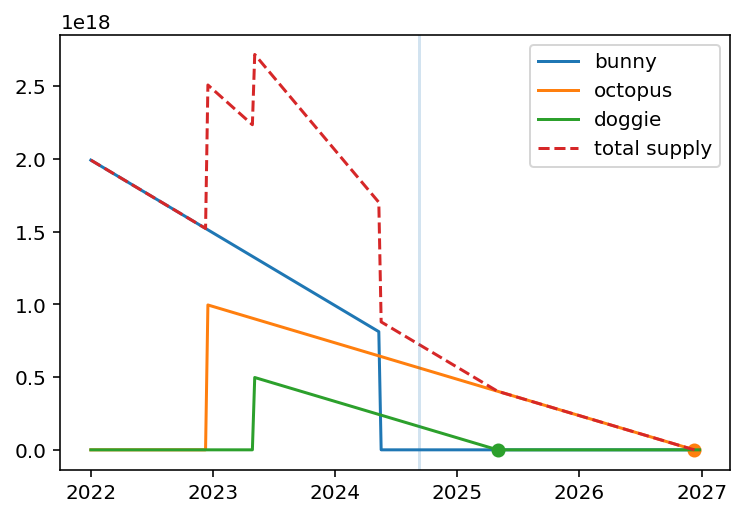

{'supply': 2000000000000000000,
 'locked': {'bunny': {'amount': 0, 'end': 0, 'decay': 0},
  'octopus': {'amount': 1000000000000000000, 'end': 1796860800, 'decay': 0},
  'doggie': {'amount': 1000000000000000000, 'end': 1746057600, 'decay': 0}},
 'epoch': 128,
 'point_history': {1: {'bias': 1991780821806969600,
   'slope': 15854895991,
   'ts': 1640995200,
   'blk': 15000000},
  2: {'bias': 1984931506738857600,
   'slope': 15854895991,
   'ts': 1641427200,
   'blk': 15028571},
  3: {'bias': 1975342465643500800,
   'slope': 15854895991,
   'ts': 1642032000,
   'blk': 15068571},
  4: {'bias': 1965753424548144000,
   'slope': 15854895991,
   'ts': 1642636800,
   'blk': 15108571},
  5: {'bias': 1956164383452787200,
   'slope': 15854895991,
   'ts': 1643241600,
   'blk': 15148571},
  6: {'bias': 1946575342357430400,
   'slope': 15854895991,
   'ts': 1643846400,
   'blk': 15188571},
  7: {'bias': 1936986301262073600,
   'slope': 15854895991,
   'ts': 1644451200,
   'blk': 15228571},
  8: {'bia

In [29]:
from datetime import datetime, timezone
start = int(datetime(2022, 1, 1, tzinfo=timezone.utc).timestamp())
block = BlockContext(number=15_000_000, timestamp=start)
msg = MessageContext(sender='bunny')

def warp_week(n=1):
    block.timestamp += WEEK * n
    block.number += 40_000 * n

veyfi = veYFI()
veyfi.init()
YFI.mint('bunny', 10 ** 21)
YFI.transfer('doggie', 10 ** 18)
YFI.transfer('octopus', 10 ** 18)

veyfi.modify_lock(2 * 10 ** 18, block.timestamp + MAX_LOCK_DURATION, 'bunny')
warp_week(50)
msg = MessageContext(sender='octopus')
veyfi.modify_lock(10 ** 18, block.timestamp + MAX_LOCK_DURATION, 'octopus')
warp_week(20)
msg = MessageContext(sender='doggie')
veyfi.modify_lock(10 ** 18, block.timestamp + MAX_LOCK_DURATION // 2, 'doggie')

msg = MessageContext(sender='bunny')

for i in range(start, int(start + MAX_LOCK_DURATION / 3), WEEK):
    warp_week()
    # veyfi.checkpoint()
    # for user in veyfi.locked:
    #     veyfi.checkpoint_user(user)
    if veyfi.locked['bunny'].end != 0 and i > start + MAX_LOCK_DURATION // 4:
        veyfi.withdraw()


veyfi.plot_balances()
veyfi.plot_supply()
veyfi.plot_block_ts()
plt.show()

veyfi.dict()